In [1]:
!pip install joblib
!pip install pandas==0.20.2

In [1]:
import google.cloud.storage as gcs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import joblib
import seaborn as sns
from datetime import datetime as dt
from sklearn.metrics import roc_curve, auc, f1_score, average_precision_score, precision_recall_curve, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
matplotlib.use('Agg')
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
palette = sns.color_palette("Set2", 10)
sns.set_palette(palette)
modelnames = ['10%', '15%', '20%', '25%', '30%', '35%', '40%', '45%', '50%']

font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
sns.set_style('whitegrid')

## Class Balance

In [3]:
client = gcs.Client('user-lifecycle')
bucket = gcs.Bucket(client, 'helder')

dsnames = ['56_30d']
models = {'lstm_10p': {'name':'LSTM'}, 'lstm_15p': {'name':'LSTM'}, 'lstm_20p': {'name':'LSTM'}, 
          'lstm_25p': {'name':'LSTM'}, 'lstm_30p': {'name':'LSTM'}, 'lstm_35p': {'name':'LSTM'}, 
          'lstm_40p': {'name':'LSTM'}, 'lstm_45p': {'name':'LSTM'}, 'lstm_50p': {'name':'LSTM'},
          'rf_10p': {'name':'Random Forest'}, 'rf_15p': {'name':'Random Forest'}, 'rf_20p': {'name':'Random Forest'}, 
          'rf_25p': {'name':'Random Forest'}, 'rf_30p': {'name':'Random Forest'}, 'rf_35p': {'name':'Random Forest'}, 
          'rf_40p': {'name':'Random Forest'}, 'rf_45p': {'name':'Random Forest'}, 'rf_50p': {'name':'Random Forest'}
         }
expname = 'class_balance'

for model, metrics in models.items():
    metrics['prec_recs'] = []
    metrics['pr_aucs'] = []
    metrics['f1s'] = []
    metrics['confusions'] = []
    metrics['roc_aucs'] =  []
    metrics['fpr_tprs'] = []
    metrics['cvs'] = []
    metrics['th_metrics'] = []  
  
    for dsname in dsnames:
        blob = gcs.Blob(name='churnr/{}/{}/{}/y_test_true_pred.gz'.format(expname, dsname, model), bucket=bucket)
        predpath = '/tmp/{}_{}_{}_y_test_true_pred.gz'.format(expname, dsname, model)
        cvpath = '/tmp/{}_{}_{}_cv_results.csv'.format(expname, dsname, model)
        with open(predpath, 'wb') as f:
            blob.download_to_file(f)
        blob = gcs.Blob(name='churnr/{}/{}/{}/cv_results.csv'.format(expname, dsname, model), bucket=bucket)
        with open(cvpath, 'wb') as f:
            blob.download_to_file(f)

        y_trpred = joblib.load(predpath)
        y_true = y_trpred[:,0]
        y_pred = y_trpred[:,1]
        y_true_ret = 1.0 - y_true 
        y_pred_ret = 1.0 - y_pred

        # calculate PR AUC
        prec, rec, thresholds = precision_recall_curve(y_true, y_pred)
        pr_auc = average_precision_score(y_true, y_pred)
        pr_auc_ret = average_precision_score(y_true_ret, y_pred_ret)

        # calculate some metrics by thresholding to 0.5, maybe it would be smarter to use on of the thresholds
        #   returned by precision_recall_curve()
        y_pred_th = np.array([0.0 if i <= 0.5 else 1.0 for i in y_pred])
        f1 = f1_score(y_true, y_pred_th)  
        prec_th, rec_th, fbeta_th, supp_th = precision_recall_fscore_support(y_true, y_pred_th)

        # calculate the confusion matrix
        cfm = confusion_matrix(y_true, y_pred_th)

        # calculate ROC curve and ROC AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        # load CV results
        cv = pd.read_csv(cvpath)

        metrics['pr_aucs'].append(pr_auc)
        metrics['prec_recs'].append((prec, rec))  
        metrics['f1s'].append(f1)
        metrics['confusions'].append(cfm)
        metrics['roc_aucs'].append(roc_auc)
        metrics['fpr_tprs'].append((fpr, tpr))
        metrics['cvs'].append(cv)
        metrics['th_metrics'].append((prec_th, rec_th, fbeta_th, (pr_auc_ret, pr_auc)))

### Precision-Recall Curves

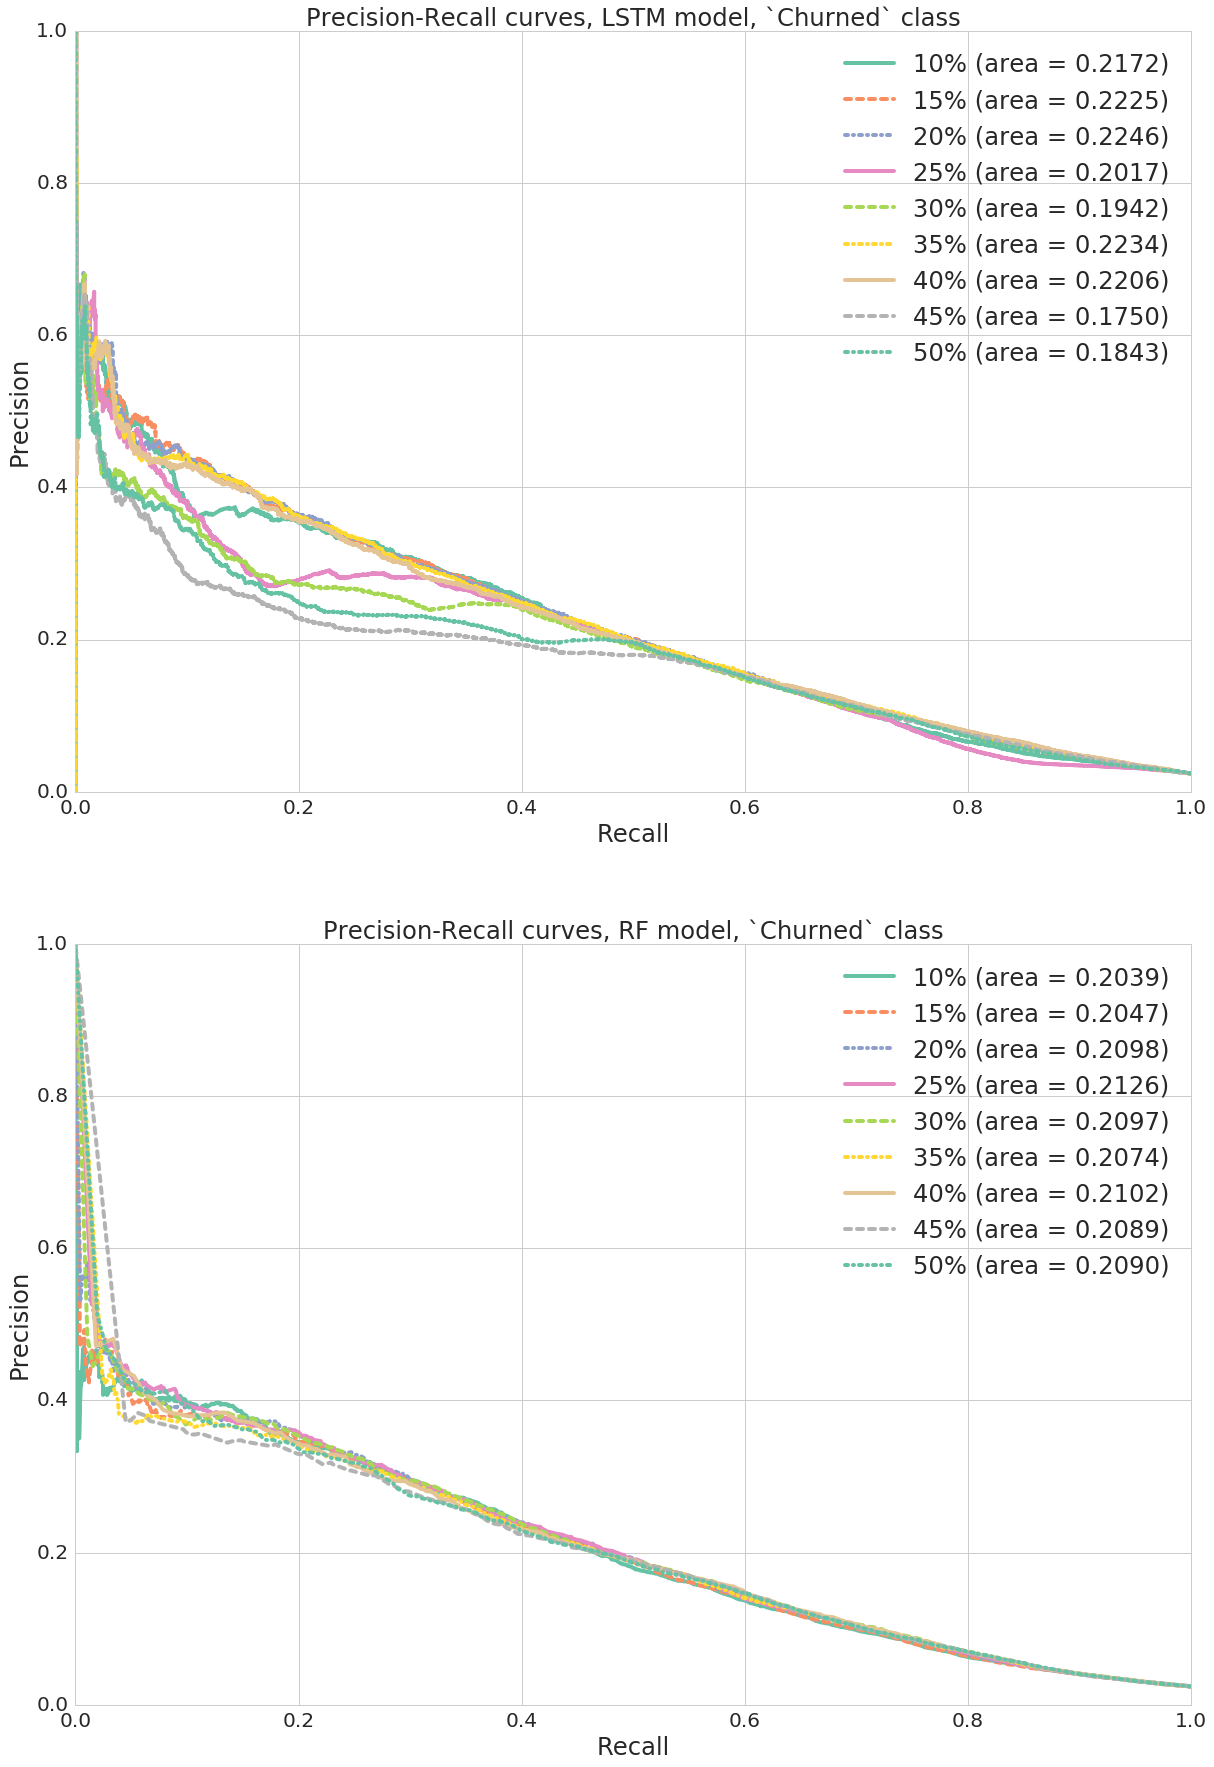

In [60]:
fig, axs = plt.subplots(nrows=2, figsize=(20,30))

linestyles = ['-', '--', '-.']*3
for ax, model in zip(axs, ['lstm', 'rf']):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('Recall', fontsize='xx-large')
    ax.set_ylabel('Precision', fontsize='xx-large')
    ax.set_title('Precision-Recall curves, {} model, `Churned` class'.format(model.upper()), fontsize='xx-large')

    for cb, ls in zip(['10p', '15p', '20p', '25p', '30p', '35p', '40p', '45p', '50p'], linestyles):
      metrics = models[model+'_'+cb]
      for prec_rec, pr_auc, dsname, f1 in zip(metrics['prec_recs'], metrics['pr_aucs'], dsnames, metrics['f1s']):
          prec = prec_rec[0]
          rec = prec_rec[1]
          ax.plot(rec, prec, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.4f})'.format(cb[:-1]+'%', pr_auc))

    ax.tick_params(labelsize='x-large')
    ax.legend(fontsize='xx-large')
#plt.savefig('prc_class_balance.pdf', bbox_inches='tight')
#!gsutil cp 'prc_class_balance.pdf' 'gs://helder/churnr/plots/prc_class_balance.pdf'

### ROC Curves

Copying file://roc_class_balance.pdf [Content-Type=application/pdf]...
-
Operation completed over 1 objects/267.0 KiB.                                    


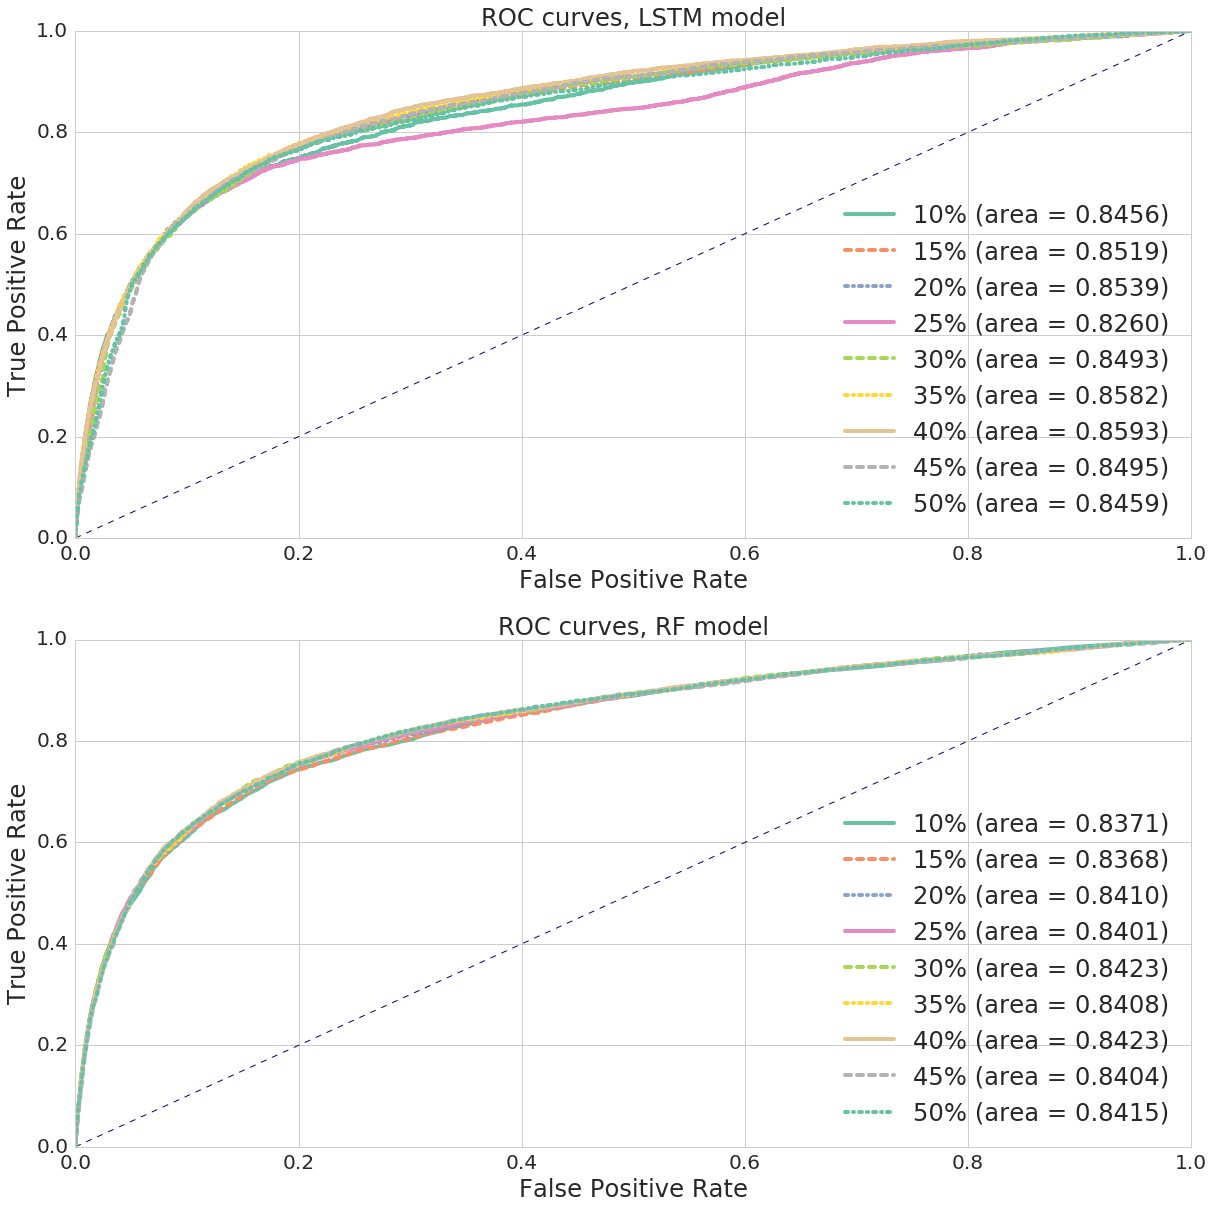

In [10]:
fig, axs = plt.subplots(nrows=2, figsize=(20,20))

linestyles = ['-', '--', '-.']*3
for ax, model in zip(axs, ['lstm', 'rf']):
  ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  ax.set_xlabel('False Positive Rate', fontsize='xx-large')
  ax.set_ylabel('True Positive Rate', fontsize='xx-large')
  ax.set_title('ROC curves, {} model'.format(model.upper()), fontsize='xx-large')
    
  for cb, ls in zip(['10p', '15p', '20p', '25p', '30p', '35p', '40p', '45p', '50p'], linestyles):
    metrics = models[model+'_'+cb]

    for fpr_tpr, roc_auc in zip(metrics['fpr_tprs'], metrics['roc_aucs']):
      fpr = fpr_tpr[0]
      tpr = fpr_tpr[1]
      ax.plot(fpr, tpr, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.4f})'.format(cb[:-1]+'%', roc_auc))
  ax.legend(fontsize='xx-large', loc='best')
  ax.tick_params(labelsize='x-large')

#plt.savefig('roc_class_balance.pdf', bbox_inches='tight')
#!gsutil cp 'roc_class_balance.pdf' 'gs://helder/churnr/plots/roc_class_balance.pdf'

### Overall scores

In [61]:
dfs_models = []
cbs = ['10p', '15p', '20p', '25p', '30p', '35p', '40p', '45p', '50p']
for model in ['lstm', 'rf']:
  dfs = []
  
  for cb in cbs:
    metric = models[model+'_'+cb]['th_metrics'][0]
    vals = {'Precision': metric[0], 'Recall': metric[1], 'F1-Score': metric[2], 'PR AUC': metric[3]}
    df = pd.DataFrame(vals, index=pd.Index(['Retained','Churned'], name='Label'))
    dfs.append(df)
  dfs = pd.concat(dfs, keys=[n[:-1]+'%' for n in cbs], names=['Share'])
  dfs_models.append(dfs)
dfs_models = pd.concat(dfs_models, keys=['LSTM', 'Random Forest'], names=['Models'])
#print(dfs_models.to_latex(multirow=True))
dfs_models

F1-Score    PR AUC  Precision    Recall
Models        Share Label                                            
LSTM          10%   Retained  0.982301  0.993983   0.983165  0.981439
                    Churned   0.307747  0.217167   0.297526  0.318695
              15%   Retained  0.975845  0.994287   0.985431  0.966443
                    Churned   0.302576  0.222515   0.236226  0.420756
              20%   Retained  0.962586  0.994360   0.988233  0.938236
                    Churned   0.270107  0.224593   0.179318  0.547105
              25%   Retained  0.966831  0.993032   0.987320  0.947174
                    Churned   0.277856  0.201676   0.191385  0.506869
              30%   Retained  0.943058  0.994174   0.990025  0.900346
                    Churned   0.222924  0.194165   0.135318  0.632237
              35%   Retained  0.941206  0.994706   0.990460  0.896618
                    Churned   0.222530  0.223431   0.134249  0.649902
              40%   Retained  0.930454  0.994734   0.991322  0.876629
                    Churned   0.205941  0.220575   0.121066  0.688911
              45%   Retained  0.923512  0.994291   0.991447  0.864289
                    Churned   0.193832  0.175024   0.112549  0.697743
              50%   Retained  0.914968  0.994161   0.991891  0.849117
                    Churned   0.183424  0.184284   0.105129  0.718597
Random Forest 10%   Retained  0.981921  0.993655   0.983035  0.980810
                    Churned   0.300023  0.203894   0.287416  0.313788
              15%   Retained  0.974738  0.993544   0.985423  0.964282
                    Churned   0.293922  0.204665   0.225561  0.421737
              20%   Retained  0.961760  0.993784   0.987977  0.936898
                    Churned   0.262594  0.209803   0.173706  0.537782
              25%   Retained  0.961340  0.993670   0.988060  0.936027
                    Churned   0.261896  0.212639   0.172719  0.541462
              30%   Retained  0.951873  0.993767   0.989192  0.917266
                    Churned   0.239996  0.209713   0.150395  0.593719
              35%   Retained  0.943922  0.993684   0.989599  0.902276
                    Churned   0.220736  0.207393   0.134480  0.615554
              40%   Retained  0.933831  0.993775   0.990513  0.883286
                    Churned   0.205684  0.210247   0.121927  0.657017
              45%   Retained  0.916083  0.993626   0.991306  0.851471
                    Churned   0.180668  0.208895   0.103779  0.697252
              50%   Retained  0.896975  0.993761   0.992056  0.818526
                    Churned   0.161539  0.208957   0.090752  0.734298

### F1-scores per share of churning users, churning class

(0.0, 0.4)

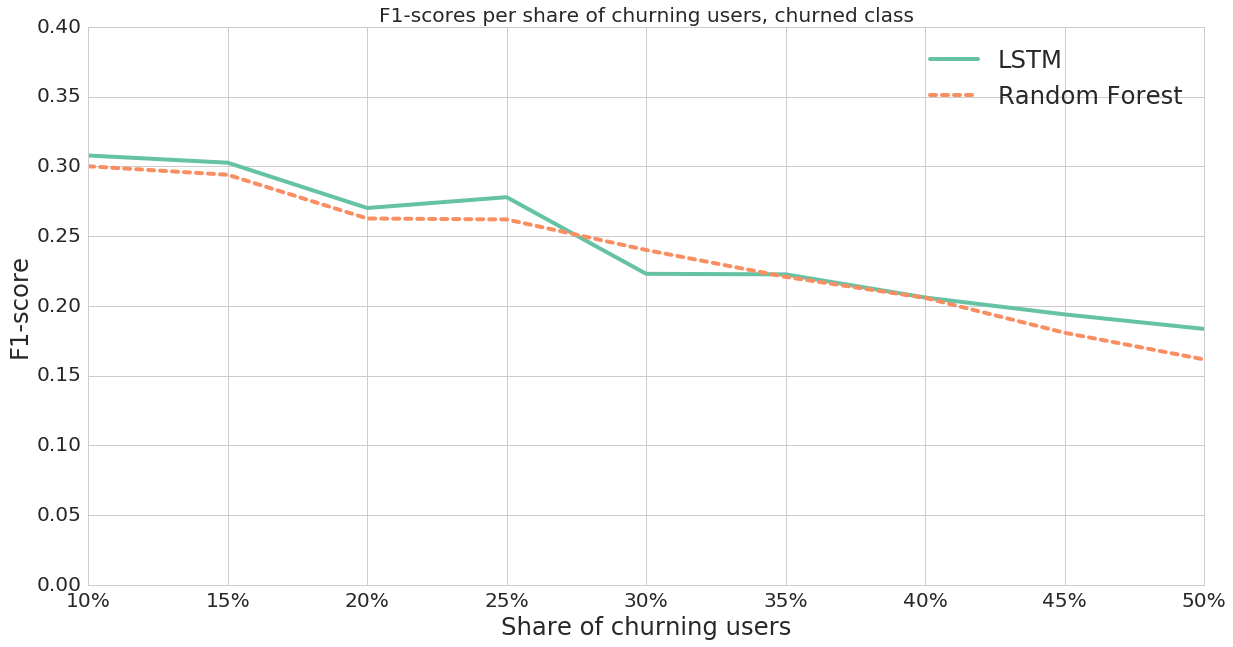

In [63]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

ax.set_title('F1-scores per share of churning users, churned class')
ax.set_xlabel('Share of churning users', fontsize='xx-large')
ax.set_ylabel('F1-score', fontsize='xx-large')

linestyles = ['-', '--']
for modeltype, ls in zip(['LSTM', 'Random Forest'], linestyles):
  vals = list(dfs_models.query("Label == 'Churned' and Models == '{}'".format(modeltype))['F1-Score'])
  ax.plot(list(range(len(vals))), vals, label=modeltype, linewidth=4.0, linestyle=ls, dash_capstyle='round')

ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='x-large')
ax.set_xticklabels(modelnames)

ax.set_ylim(0.0, 0.4)

#plt.savefig('line_class_balance.pdf', bbox_inches='tight')
#!gsutil cp 'line_class_balance.pdf' 'gs://helder/churnr/plots/line_class_balance.pdf'

(0.6, 1.0)

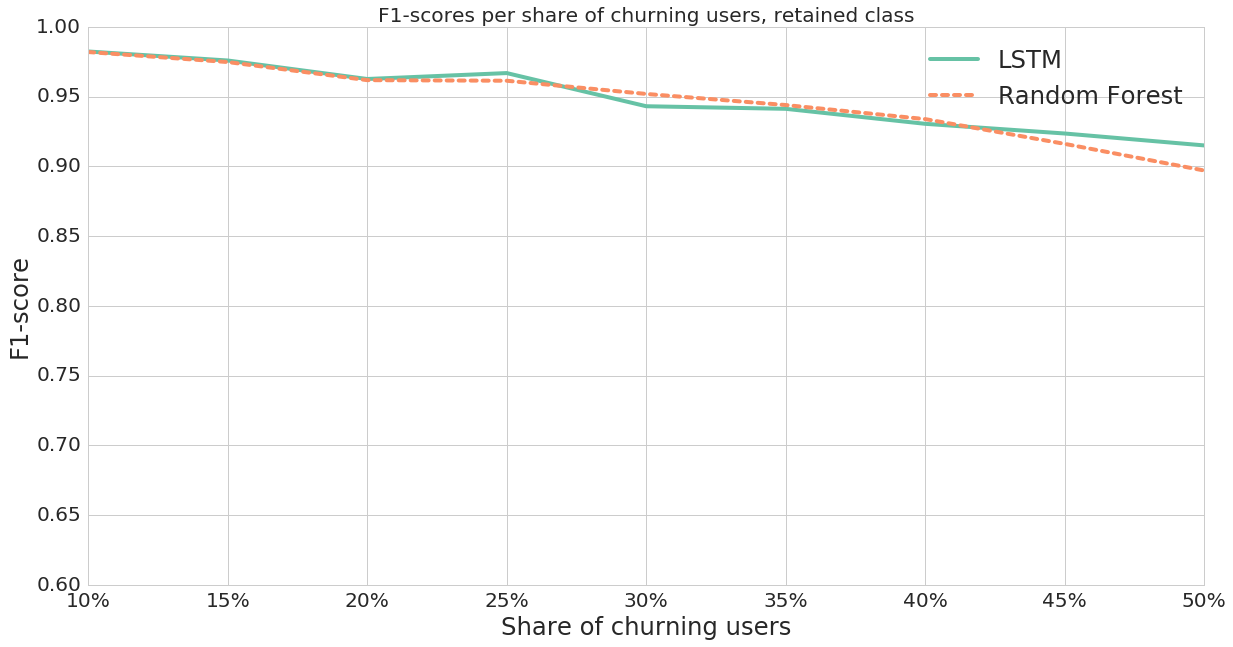

In [64]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

ax.set_title('F1-scores per share of churning users, retained class')
ax.set_xlabel('Share of churning users', fontsize='xx-large')
ax.set_ylabel('F1-score', fontsize='xx-large')

linestyles = ['-', '--']
for modeltype, ls in zip(['LSTM', 'Random Forest'], linestyles):
  vals = list(dfs_models.query("Label == 'Retained' and Models == '{}'".format(modeltype))['F1-Score'])
  ax.plot(list(range(len(vals))), vals, label=modeltype, linewidth=4.0, linestyle=ls, dash_capstyle='round')

ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='x-large')
ax.set_xticklabels(modelnames)

ax.set_ylim(0.6, 1.0)

#plt.savefig('line_class_balance_retained.pdf', bbox_inches='tight')
#!gsutil cp 'line_class_balance_retained.pdf' 'gs://helder/churnr/plots/line_class_balance_retained.pdf'

### Precision and recall plots over different shares of churning users

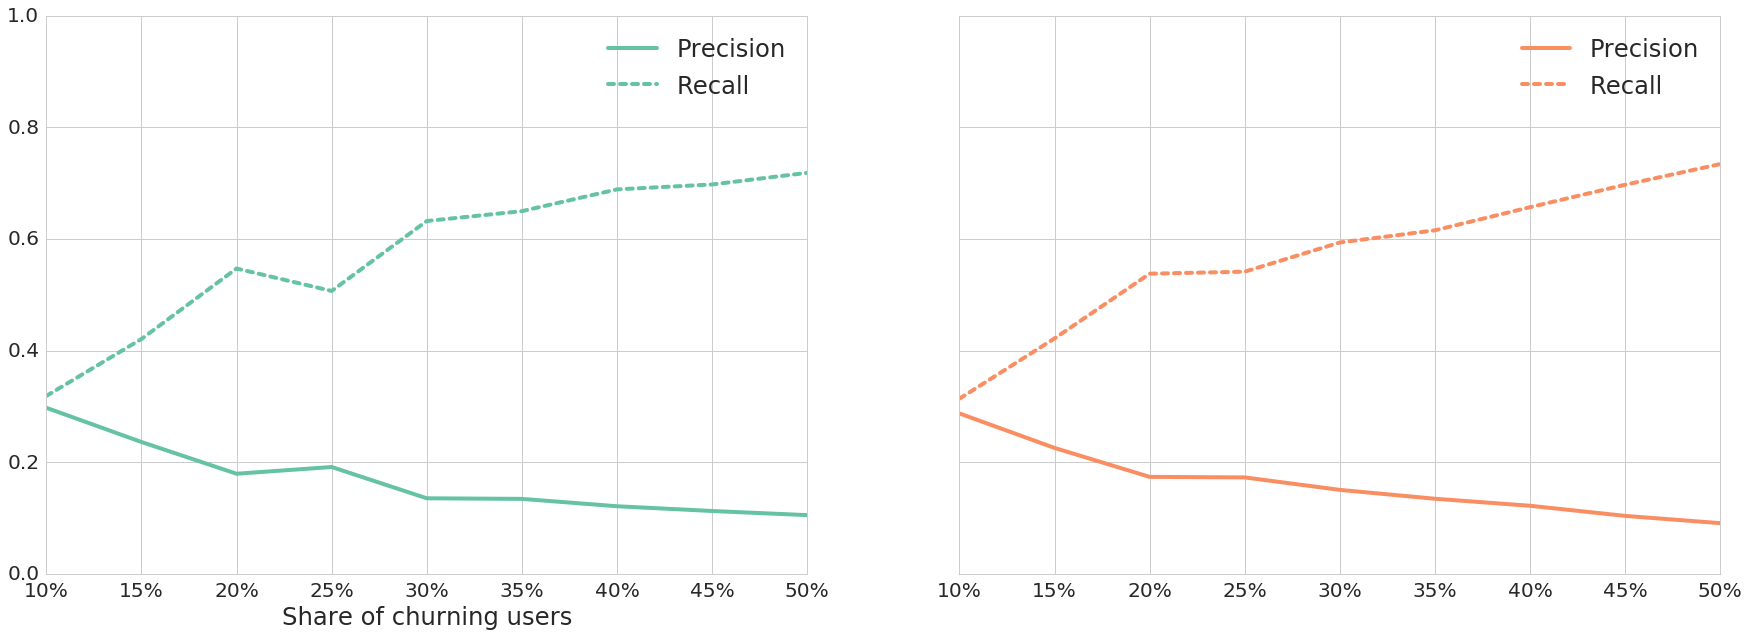

In [69]:
fig, axs = plt.subplots(ncols=2, figsize=(30,10), sharey=True)

for modeltype, ax, color in zip(['LSTM', 'Random Forest'], axs, palette):
  vals = list(dfs_models.query("Label == 'Churned' and Models == '{}'".format(modeltype))['Precision'])
  ax.plot(list(range(len(vals))), vals, label='Precision', linewidth=4.0, linestyle='-', dash_capstyle='round', color=color)
  
  vals = list(dfs_models.query("Label == 'Churned' and Models == '{}'".format(modeltype))['Recall'])
  ax.plot(list(range(len(vals))), vals, label='Recall', linewidth=4.0, linestyle='--', dash_capstyle='round', color=color)

  ax.legend(fontsize='xx-large', loc='best')
  ax.tick_params(labelsize='x-large')
  ax.set_xticklabels(modelnames)
  ax.set_ylim(0.0, 1.0)
  
  if modeltype == 'LSTM':
    ax.set_xlabel('Share of churning users', fontsize='xx-large')

#plt.savefig('prl_class_balance.pdf', bbox_inches='tight')
#!gsutil cp 'prl_class_balance.pdf' 'gs://helder/churnr/plots/prl_class_balance.pdf'

Copying file://prl_class_balance_retained.pdf [Content-Type=application/pdf]...
/ [1 files][ 12.7 KiB/ 12.7 KiB]                                                
Operation completed over 1 objects/12.7 KiB.                                     


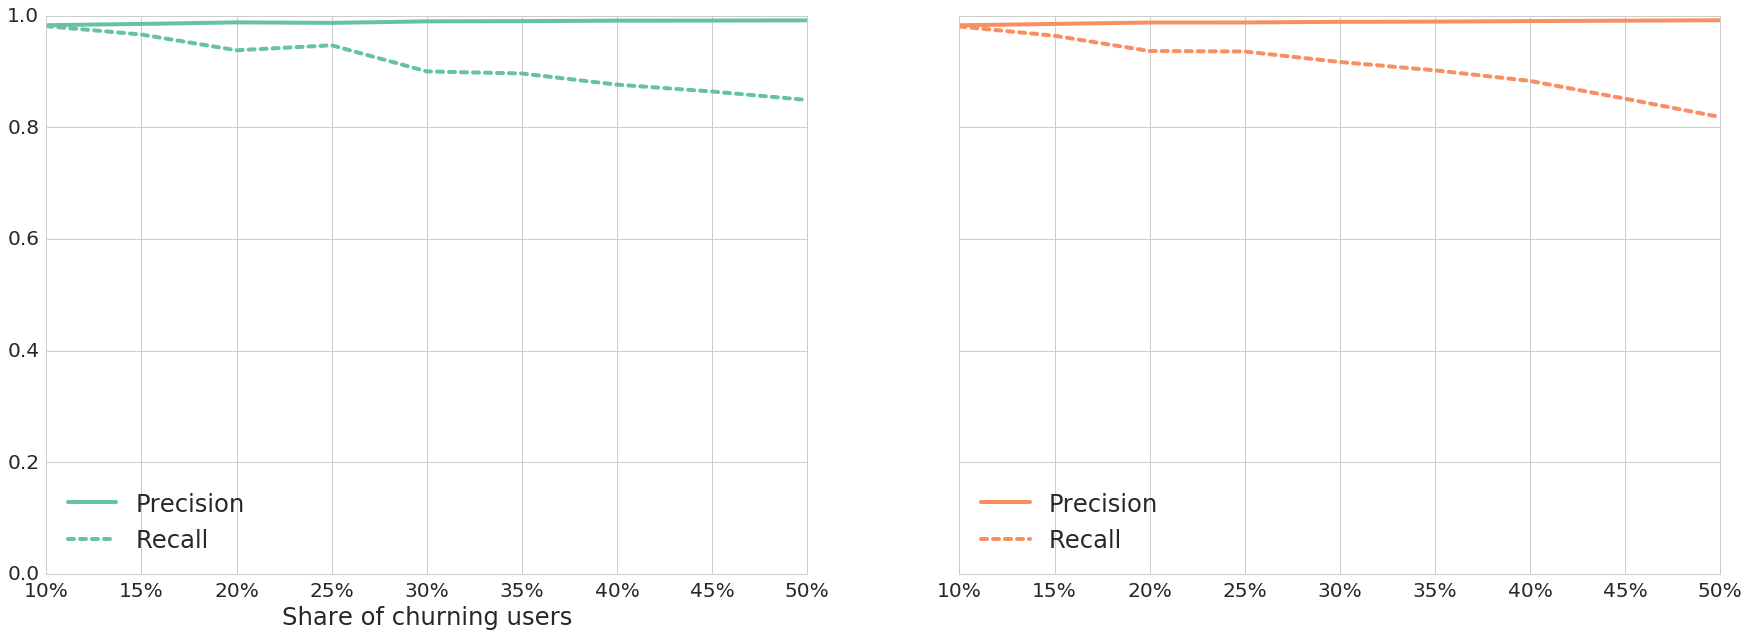

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(30,10), sharey=True)

for modeltype, ax, color in zip(['LSTM', 'Random Forest'], axs, palette):
  vals = list(dfs_models.query("Label == 'Retained' and Models == '{}'".format(modeltype))['Precision'])
  ax.plot(list(range(len(vals))), vals, label='Precision', linewidth=4.0, linestyle='-', dash_capstyle='round', color=color)
  
  vals = list(dfs_models.query("Label == 'Retained' and Models == '{}'".format(modeltype))['Recall'])
  ax.plot(list(range(len(vals))), vals, label='Recall', linewidth=4.0, linestyle='--', dash_capstyle='round', color=color)

  ax.legend(fontsize='xx-large', loc='best')
  ax.tick_params(labelsize='x-large')
  ax.set_xticklabels(modelnames)
  ax.set_ylim(0.0, 1.0)
  
  if modeltype == 'LSTM':
    ax.set_xlabel('Share of churning users', fontsize='xx-large')

#plt.savefig('prl_class_balance_retained.pdf', bbox_inches='tight')
#!gsutil cp 'prl_class_balance_retained.pdf' 'gs://helder/churnr/plots/prl_class_balance_retained.pdf'